# Instrument visualisation

RAMP contains a simple matplotlib interface for instrument visualisation. This can be used for debugging instrument definition files, and checking that components possess the correct orientation.

In [1]:
import mcramp as mcr
import pyopencl as cl
import numpy as np

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

## Basic visualisation

The simplest possible instrument visualisation is carried out using the ``visualise()`` member function of the RAMP instrument class. For demonstration, we will load the simplified power spectrometer instrument used elsewhere in the documentation.

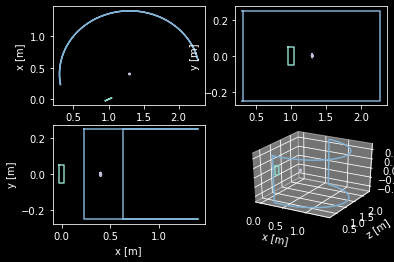

In [2]:
inst = mcr.Instrument(
    'powder.json', 
    ctx, 
    queue, 
    Ei=9.09, 
    Mono_angle=0.4635, 
    detector_binning=[-40.0, 1.0, 140.0]
)
inst.visualise(controls=False)

This basic visualisation contains 4 projects of the instrument: 3 orthogonal and 1 three dimensional projection. These plots have the usual matplotlib interactivity supported by the environment in which they are being run.

## Visualisation controls

The ``visualise()`` command takes a Boolean argument called ``controls``. When ``controls`` is ``True`` (NOTE: this is the default value for ``controls``!), matplotlib will attempt to provide interactive controls for the plots. Depending on this environment, this may not be possible (a prominent example being Google Colab, which does not support the required matplotlib Jupyter widgets).

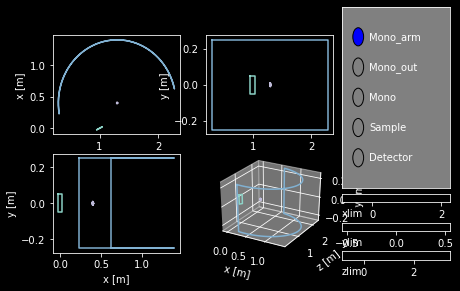

In [3]:
inst.visualise(controls=True)

In the case of the notebook platform I am currently writing on, this is not available as it is not supported by the documentation engine! However, there is support for interactive matplotlib widgets in locally executed Jupyter/IPython notebooks (left as an exercise to the reader). Executing RAMP scripts on a native Python installation with matplotlib installed should support these interactive widgets.

In lieu of the availability of interactive controls, there are several parameters for the ``visualise()`` command to control the plots.

 - ``[x/y/z]lim`` controls the limits of the ``[x/y/z]`` axis of every plot, suupplied as a 2-tuple or 2 element list.
 - ``focus`` is the name of a component in the instrument definition file upon which the visualisation will be centered. The zero of the plot axes will be changed to the position of the focused component, and the axis limits will be adjusted such that by default only the region of the instrument close to the focussed component is in view.

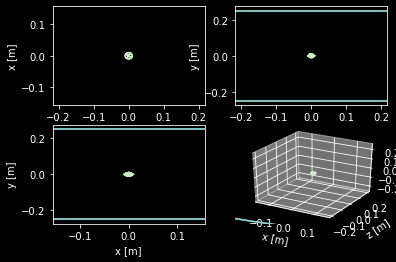

In [4]:
inst.visualise(controls=False, focus='Sample')

Finally, any additional keyword arguments supplied to ``visualise()`` other than those listed above will be given to the ``matplotlib.pyplot.figure()`` call which instantiates the plot. This can be used to control several plotting parameters, e.g. the figure size.

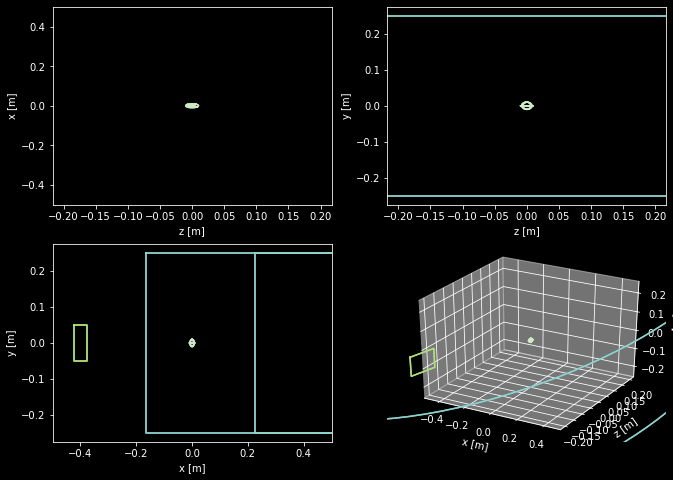

In [5]:
inst.visualise(controls=False, focus='Sample', xlim=[-0.5, 0.5], figsize=(11, 8))

Hiding components
-----------------

A component with the ``"visualise": false`` parameter in the instrument definition file will be ignored by visualisation, e.g.

```
        "Detector" : {
            "position" : [0.0, 0.0, 0.0],
            "relative" : "Sample",
            "visualise" : false,
            "geom_kernel" : {
                "name" : "GBanana",
                "radius" : 1.0,
                "height" : 3.0,
                "mintheta" : -40.0,
                "maxtheta" : 140.0
            },
            "scat_kernel" : {
                "name" : "SDetector1D",
                "var" : "theta",
                "binning" : $detector_binning$,
                "restore_neutron" : true
            }
        }
```

Trace lines
-----------

Finally, visualisations will plot trace lines of neutron trajectories if the instrument has been ``execute``d prior to visualisation with the argument ``trace=True``. Please note that this should only be done with an extremely small number of neutrons trajectores (``N ~ 1000``) otherwise the visualisation will be much too resource intensive (matplotlib is not very efficient!).

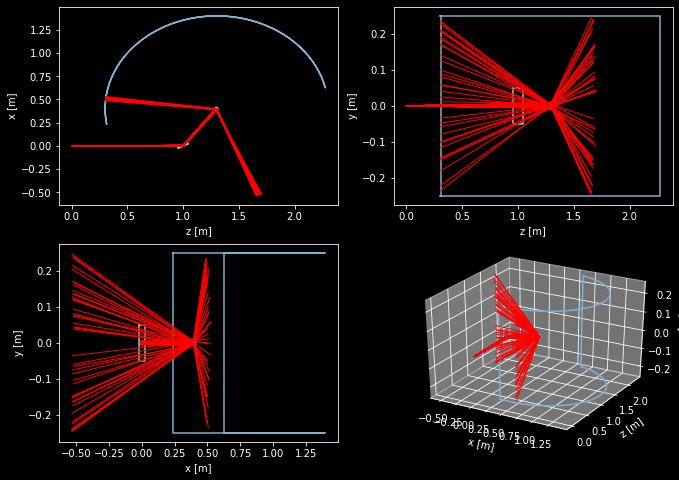

In [7]:
inst.execute(300, trace=True)
inst.visualise(controls=False, figsize=(11,8))

There are a few important gotchas with traces that are important to note. These all follow from the way that the trace lines are saved during the simulation execution, so I will detail this process here. After each geometry kernel is executed, a line is plotted between the earliest intersection with the current and previous geometry kernels IF the neutron is not subsequently terminated when the scattering kernel is executed. For most users, understanding this process is not terribly important but it could explain some of the following strange behaviour in a trace:

 - If ``arm`` components are visualised, they will appear to 'spread' the neutron beam due to how the kernel alters the intersection buffer to pass neutrons through. This effect is not actually happening in the simulation! However, this can be removed from the ``trace`` by using the ``"visualise": false`` parameter to disable visualisation of ``arm``s.
 - Trace lines leading to detectors will not be visualised unless the ``restore_neutron`` flag is used in the detector the prevent it terminating the neutron.

Please note this is currently an ongoing list!